# Introduction

This is a data exploration notebook on the dataset (downloadable [here](https://userinterfaces.aalto.fi/136Mkeystrokes/)) consists of typing data from 136 million keystrokes of 168 thousands users.

# Importing Libraries and Datasets

* `meta_data` -- the meta data of the participants
* `data`, `train_data`, `dev_data`, `test_data` -- keystoke data of the participants

In [1]:
# %%capture
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import matplotlib.pyplot as plt

import re
import os
import random
import time
import datetime
from pytz import timezone

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

import sys
sys.path.append('../')
import helper

tf.config.list_physical_devices('GPU')

Hello from helper.py


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
meta_filepath = "../data/meta_data/metadata_participants.txt"
meta_data = helper.processing_meta(meta_filepath)

In [3]:
maindata_path = "../data/keystroke_data_7001"
sample_size = 100
train_size = 0.7
dev_size = 0.15
data, train_data, dev_data, test_data, KEYCODE_enc, K1_K2_enc, K1_enc, K2_enc = helper.processing_folder(maindata_path, sample_size, train_size, dev_size)

# First Impression

## Raw Keystroke Data

In [4]:
print(f"There are in total {len(train_data['PARTICIPANT_ID'].unique())} many users contained in the train dataset")
print(f"There are in total {len(dev_data['PARTICIPANT_ID'].unique())} many users contained in the dev dataset")
print(f"There are in total {len(test_data['PARTICIPANT_ID'].unique())} many users contained in the test dataset")
print(f"There are in total {len(data['PARTICIPANT_ID'].unique())} many users contained in the entire dataset")
print(f"There are in total {len(data)} many keystrokes contained in the dataset")

There are in total 100 many users contained in the train dataset
There are in total 100 many users contained in the dev dataset
There are in total 100 many users contained in the test dataset
There are in total 100 many users contained in the entire dataset
There are in total 74404 many keystrokes contained in the dataset


In [5]:
data.head(3)

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE,INDEX
0,5,7,The others raise their eyebrows.,The others raise their eyebrows,204,1471934383592,1471934383760,SHIFT,16,0
1,5,7,The others raise their eyebrows.,The others raise their eyebrows,203,1471934383701,1471934383760,T,84,1
2,5,7,The others raise their eyebrows.,The others raise their eyebrows,205,1471934383838,1471934383910,h,72,2


> See if `TEST_SECTION_ID` is unique for each setence.

In [6]:
id_sentence_pair = data[['TEST_SECTION_ID', 'SENTENCE']].apply(tuple, axis=1)

In [7]:
len(id_sentence_pair.unique()) == len(data['TEST_SECTION_ID'].unique())

True

## Keycode

In [8]:
len(data['KEYCODE'].unique())

77

In [9]:
data['KEYCODE'].value_counts()[:20]

32     11022
69      6657
84      4843
8       4664
79      4263
65      4157
73      4091
78      3642
83      3212
82      2908
72      2687
16      2377
76      2309
68      1980
85      1647
77      1443
87      1417
67      1383
89      1318
190     1247
Name: KEYCODE, dtype: int64

In [10]:
def return_keycode_dict(data, keycode_col, letter_col):
    keycode_dict = {}
    for keycode in data[keycode_col].unique():
        keycode_dict[keycode] = data[data[keycode_col] == keycode][letter_col].unique()
    return keycode_dict
keycode_letter_pairing = return_keycode_dict(data, 'KEYCODE', 'LETTER')
keycode_letter_pairing['16']

array(['SHIFT', 'H', 'C', 'S', 'I', '|', '', 'L', 'Y', 'M'], dtype=object)

> The javascript keycode `16` is supposed to uniquely corresponds to the `SHIFT` key; however, there are many data entry errors.

## Raw Meta Data of Users

In [11]:
meta_data.head(3)

,PARTICIPANT_ID,AGE,GENDER,HAS_TAKEN_TYPING_COURSE,COUNTRY,LAYOUT,NATIVE_LANGUAGE,FINGERS,TIME_SPENT_TYPING,KEYBOARD_TYPE,ERROR_RATE,AVG_WPM_15,AVG_IKI,ECPC,KSPC,ROR
0,3,30,none,True,US,qwerty,en,1,8,full,0.5,61.9,169.2,0.1,1.2,0.2
1,5,27,female,True,MY,qwerty,en,7,6,laptop,0.9,72.9,150.5,0.0,1.1,0.4
2,7,13,female,True,AU,qwerty,en,7,0,laptop,6.7,24.2,386.6,0.1,1.3,0.1


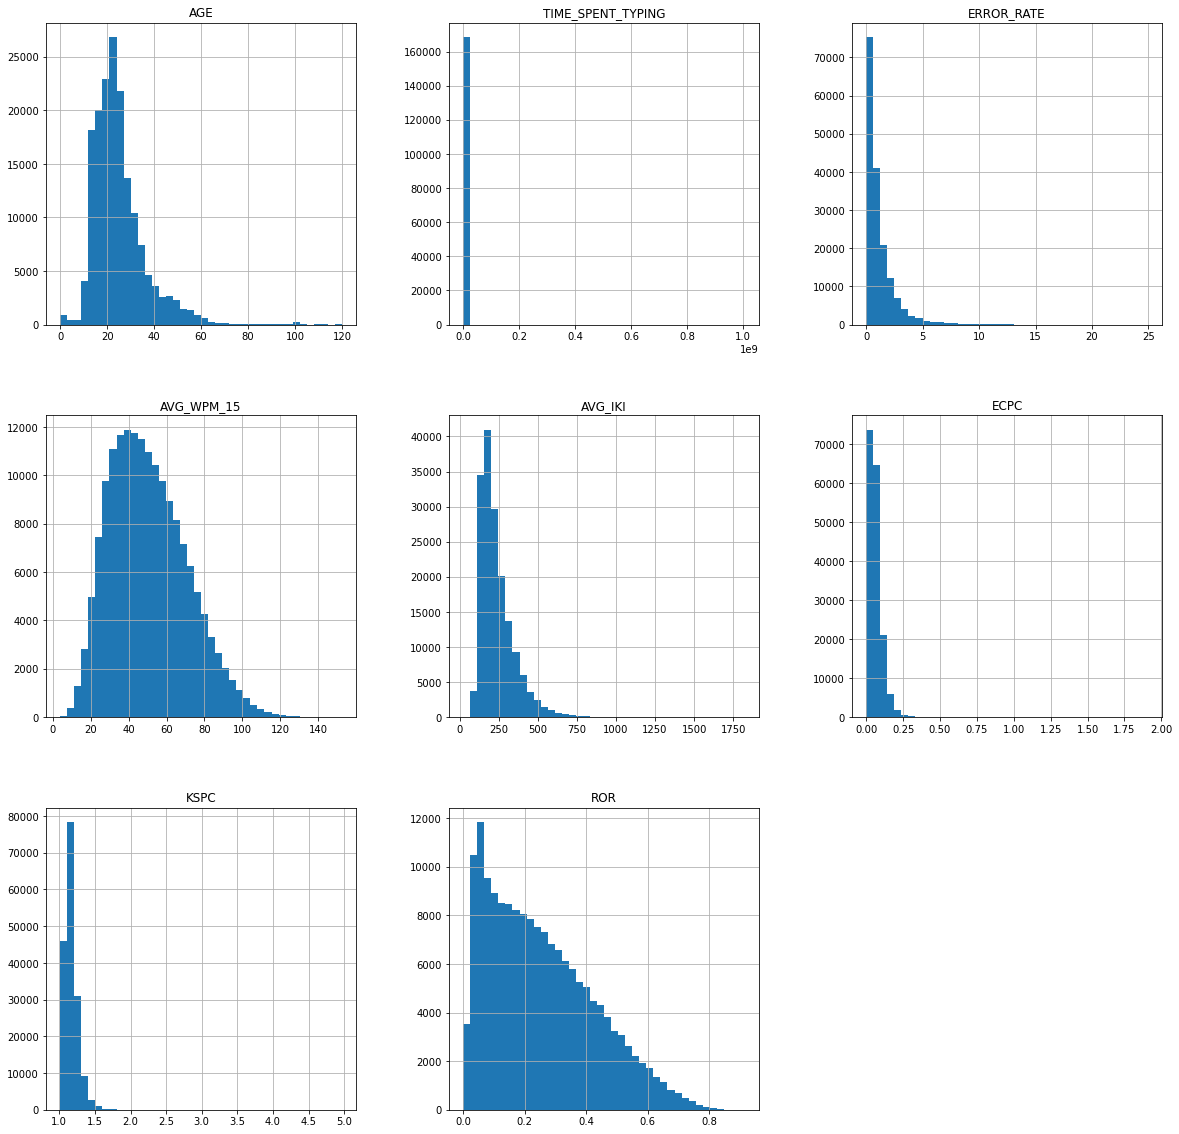

In [12]:
meta_data.hist(figsize=(20, 20), bins=40);

In [13]:
meta_data['TIME_SPENT_TYPING'].value_counts()[:24]

1     54230
2     29473
3     14605
0     14451
8     12197
5     11897
4     11714
6      7658
10     3015
7      2956
12     1537
9      1491
20      449
15      420
24      406
30      244
16      190
14      178
18      117
13      116
40      114
23      109
11      107
25       79
Name: TIME_SPENT_TYPING, dtype: int64

In [14]:
meta_data[meta_data['AGE'] == 120]

,PARTICIPANT_ID,AGE,GENDER,HAS_TAKEN_TYPING_COURSE,COUNTRY,LAYOUT,NATIVE_LANGUAGE,FINGERS,TIME_SPENT_TYPING,KEYBOARD_TYPE,ERROR_RATE,AVG_WPM_15,AVG_IKI,ECPC,KSPC,ROR
25872,77364,120,none,True,US,qwerty,en,1,24,laptop,0.1,61.9,180.3,0.0,1.1,0.2
27903,83115,120,none,True,US,qwerty,en,9,25,laptop,0.7,53.0,163.0,0.2,1.4,0.2
40985,122862,120,female,True,US,qwerty,en,1,30,laptop,0.5,42.9,213.2,0.1,1.3,0.2
42746,127900,120,male,True,VU,azerty,ig,9,900,on-screen,0.7,39.4,253.2,0.1,1.2,0.2
91615,277584,120,female,True,US,qwerty,en,9,1,full,1.0,31.0,298.4,0.1,1.3,0.1
108228,326644,120,none,True,US,qwerty,en,9,24,laptop,1.5,13.2,705.7,0.1,1.2,0.0
112079,338378,120,female,True,US,qwerty,en,9,5,laptop,0.8,48.4,228.3,0.0,1.1,0.1
115226,348210,120,none,True,ZW,dvorak,my,1,4,on-screen,3.6,60.4,106.3,0.1,1.1,0.6
155070,474512,120,female,True,US,qwerty,en,9,0,full,0.4,45.4,204.4,0.1,1.3,0.3


**A couple remarks:**

> 1. Something is clearly wrong with the column `TIME_SPENT_TYPING`: according to the README of the dataset provided by the dataset authors, this column should be: **Number of hours spent typing everyday**. Perhaps a lot of the participant mistook "hours" for "minutes"
> 2. Most of the quantitativ data are very skewed to the left, suggesting that there are many outliers.
> 3. The `AGE` + `FINGERS` + `AVG_WPM_15` looks suspicious.. I highly doubt if the bio-information about the users such as `AGE` and `FINGERS` and `TIME_SPEND_TYPING` are entered truthfully.

## Piecing `meta_data` and `data` to => `all_merged_data`

In [15]:
merged_data = data.copy()

for user in merged_data['PARTICIPANT_ID'].unique():
    meta_info = meta_data[meta_data['PARTICIPANT_ID'] == user]
    mask_user = merged_data['PARTICIPANT_ID'] == user
    merged_data.loc[mask_user, 'ROR'] = meta_info['ROR'].iloc[0]

merged_data['ROR'].isnull().sum()

0

In [16]:
merged_data.head(3)

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE,INDEX,ROR
0,5,7,The others raise their eyebrows.,The others raise their eyebrows,204,1471934383592,1471934383760,SHIFT,16,0,0.4
1,5,7,The others raise their eyebrows.,The others raise their eyebrows,203,1471934383701,1471934383760,T,84,1,0.4
2,5,7,The others raise their eyebrows.,The others raise their eyebrows,205,1471934383838,1471934383910,h,72,2,0.4


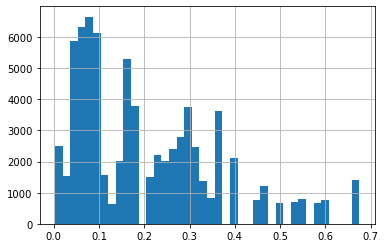

In [17]:
merged_data['ROR'].hist(bins=40);

In [18]:
all_merged_data = data.copy()
meta_features = ['LAYOUT', 'ERROR_RATE', 'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR']

for user in all_merged_data['PARTICIPANT_ID'].unique():
    meta_info = meta_data[meta_data['PARTICIPANT_ID'] == user]
    mask_user = all_merged_data['PARTICIPANT_ID'] == user
    for feature in meta_features:
        all_merged_data.loc[mask_user, feature] = meta_info[feature].iloc[0]

all_merged_data = all_merged_data.rename(columns={'ERROR_RATE':'ERR', 'AVG_WPM_15':'WPM', 'AVG_IKI':'IKI'})

In [19]:
all_merged_data.head(3)

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE,INDEX,LAYOUT,ERR,WPM,IKI,ECPC,KSPC,ROR
0,5,7,The others raise their eyebrows.,The others raise their eyebrows,204,1471934383592,1471934383760,SHIFT,16,0,qwerty,0.9,72.9,150.5,0.0,1.1,0.4
1,5,7,The others raise their eyebrows.,The others raise their eyebrows,203,1471934383701,1471934383760,T,84,1,qwerty,0.9,72.9,150.5,0.0,1.1,0.4
2,5,7,The others raise their eyebrows.,The others raise their eyebrows,205,1471934383838,1471934383910,h,72,2,qwerty,0.9,72.9,150.5,0.0,1.1,0.4


In [20]:
all_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74404 entries, 0 to 74403
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PARTICIPANT_ID   74404 non-null  object 
 1   TEST_SECTION_ID  74404 non-null  object 
 2   SENTENCE         74404 non-null  object 
 3   USER_INPUT       74404 non-null  object 
 4   KEYSTROKE_ID     74404 non-null  object 
 5   PRESS_TIME       74404 non-null  object 
 6   RELEASE_TIME     74404 non-null  object 
 7   LETTER           74404 non-null  object 
 8   KEYCODE          74404 non-null  object 
 9   INDEX            74404 non-null  int64  
 10  LAYOUT           74404 non-null  object 
 11  ERR              74404 non-null  float64
 12  WPM              74404 non-null  float64
 13  IKI              74404 non-null  float64
 14  ECPC             74404 non-null  float64
 15  KSPC             74404 non-null  float64
 16  ROR              74404 non-null  float64
dtypes: float64(6

# Extract Features from `data`

## Overview of the Extracted Features => `data_extractor`

In [21]:
data_extractor = helper.Extractor(data)

### Original unigraph and digraph

In [22]:
data_extractor.unigraph.head(3)

,USER,KEYCODE,INDEX,HL,IL,RL,PL
0,5,16,0.0,168.0,-59.0,0.0,109.0
1,5,84,1.0,59.0,78.0,150.0,137.0
2,5,72,2.0,72.0,0.0,81.0,72.0


In [23]:
data_extractor.digraph.head(3)

,USER,K1,K2,I1,I2,HL1,HL2,IL,RL,PL
0,5,16,84,0.0,1.0,168.0,59.0,-59.0,0.0,109.0
1,5,84,72,1.0,2.0,59.0,72.0,78.0,150.0,137.0
2,5,72,69,2.0,3.0,72.0,81.0,0.0,81.0,72.0


### Avergae mode: `mean` or `median` => the **Average User**

In [24]:
avg_mode = 'mean'
data_extractor.unigraph_avg(avg_mode).head(3)

,USER,KEYCODE,INDEX,HL,PL,IL,RL
0,5,16,0.0,348.0,263.0,-85.0,29.0
1,5,84,1.0,105.0,225.0,120.0,227.0
2,5,72,2.0,97.0,212.0,114.0,228.0


In [25]:
data_extractor.digraph_avg(avg_mode).head(3)

,USER,K1,K2,I1,I2,HL1,HL2,PL,IL,RL
0,5,16,84,0.0,1.0,299.0,107.0,221.0,-77.0,29.0
1,5,84,72,1.0,2.0,102.0,97.0,154.0,52.0,149.0
2,5,72,69,2.0,3.0,96.0,111.0,174.0,77.0,189.0


In [26]:
avg_mode = 'median'
data_extractor.unigraph_avg(avg_mode).head(3)

,USER,KEYCODE,INDEX,HL,PL,IL,RL
0,5,16,0.0,260.0,172.0,-81.0,23.0
1,5,84,1.0,97.0,154.0,52.0,160.0
2,5,72,2.0,93.0,144.0,48.0,165.0


In [27]:
data_extractor.digraph_avg(avg_mode).head(3)

,USER,K1,K2,I1,I2,HL1,HL2,PL,IL,RL
0,5,16,84,0.0,1.0,248.0,99.0,168.0,-75.0,32.0
1,5,84,72,1.0,2.0,96.0,92.0,122.0,24.0,120.0
2,5,72,69,2.0,3.0,93.0,106.0,129.0,33.0,145.0


### Orginial `data_df` with Added Keyboard Keycode Distance Encoding

In [28]:
data_extractor.unigraph_keyboard(avg_mode=None).head(3)

,USER,KEYCODE,INDEX,HD,HL,IL,RL,PL
0,5,16,0.0,4.0,168.0,-59.0,0.0,109.0
1,5,84,1.0,2.0,59.0,78.0,150.0,137.0
2,5,72,2.0,1.0,72.0,0.0,81.0,72.0


In [29]:
data_extractor.digraph_keyboard(avg_mode=None).head(3)

,USER,K1,K2,I1,I2,KD,HD,HL1,HL2,IL,RL,PL
0,5,16,84,0.0,1.0,5,3.0,168.0,59.0,-59.0,0.0,109.0
1,5,84,72,1.0,2.0,2,1.5,59.0,72.0,78.0,150.0,137.0
2,5,72,69,2.0,3.0,4,1.5,72.0,81.0,0.0,81.0,72.0


### Added keyboard encoding with the **Average User**

In [30]:
avg_mode = 'mean'
data_extractor.unigraph_keyboard(avg_mode).head(3)

,USER,KEYCODE,INDEX,HD,HL,PL,IL,RL
0,5,16,0.0,4.0,348.0,263.0,-85.0,29.0
1,5,84,1.0,2.0,105.0,225.0,120.0,227.0
2,5,72,2.0,1.0,97.0,212.0,114.0,228.0


In [31]:
data_extractor.digraph_keyboard(avg_mode).head(3)

,USER,K1,K2,I1,I2,KD,HD,HL1,HL2,PL,IL,RL
0,5,16,84,0.0,1.0,5,3.0,299.0,107.0,221.0,-77.0,29.0
1,5,84,72,1.0,2.0,2,1.5,102.0,97.0,154.0,52.0,149.0
2,5,72,69,2.0,3.0,4,1.5,96.0,111.0,174.0,77.0,189.0


In [32]:
avg_mode = 'median'
data_extractor.unigraph_keyboard(avg_mode).head(3)

,USER,KEYCODE,INDEX,HD,HL,PL,IL,RL
0,5,16,0.0,4.0,260.0,172.0,-81.0,23.0
1,5,84,1.0,2.0,97.0,154.0,52.0,160.0
2,5,72,2.0,1.0,93.0,144.0,48.0,165.0


In [33]:
data_extractor.digraph_keyboard(avg_mode).head(3)

,USER,K1,K2,I1,I2,KD,HD,HL1,HL2,PL,IL,RL
0,5,16,84,0.0,1.0,5,3.0,248.0,99.0,168.0,-75.0,32.0
1,5,84,72,1.0,2.0,2,1.5,96.0,92.0,122.0,24.0,120.0
2,5,72,69,2.0,3.0,4,1.5,93.0,106.0,129.0,33.0,145.0


### Apply Filters **(on user-level)**: choose from 
* `ABS` -- filter by a fix number of maxima and/or minima
* `IQR` -- filter by quartile scale:
    * max = 3rd-quartile + fold * IQR
    * min = 1st-quartile - fold * IQR

In [34]:
avg_mode = None
encode_keyboard = False
outlier_filter = 'ABS'
bounds_dict = {'PL': [0, 10]}
filtered_data = data_extractor.unigraph_filtered(avg_mode, 
                                          encode_keyboard, 
                                          outlier_filter, 
                                          bounds_dict)
unfiltered_data = data_extractor.unigraph

> A list of users' Press Latency Distributions with **Unfiltered Data**

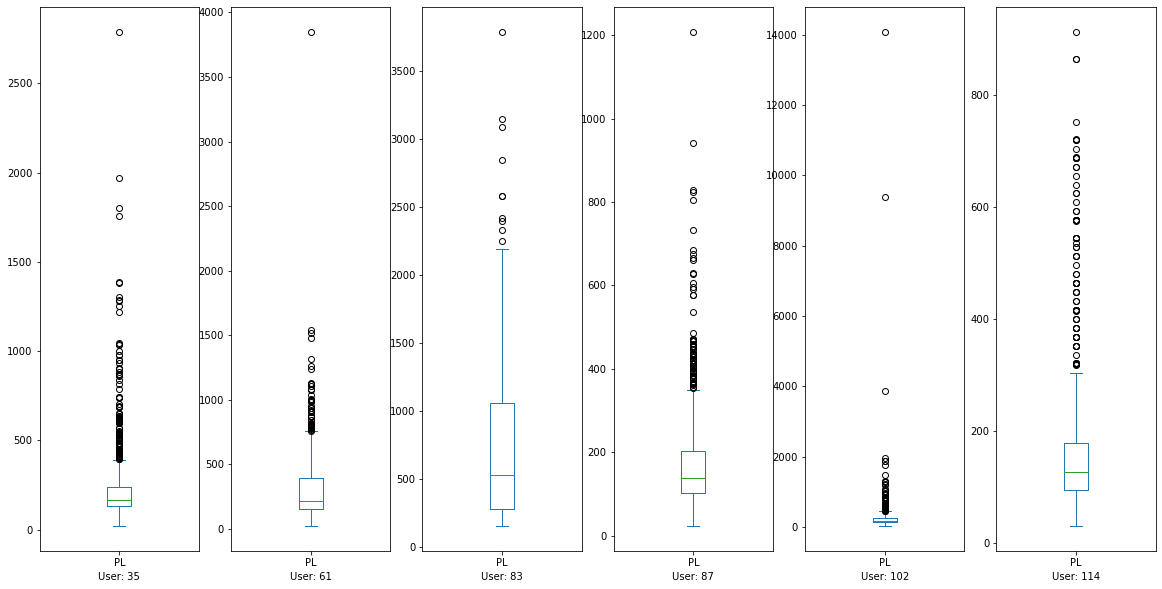

In [35]:
users = ['35', '61', '83', '87', '102', '114']
fig, ax = plt.subplots(1, 6, figsize=(20, 10))
for i, user in enumerate(users):
    mask = unfiltered_data['USER'] == user
    unfiltered_data.loc[mask, 'PL'].plot.box(ax=ax[i])
    ax[i].set_xlabel(f'User: {user}')

> The same list of users' Press Latency Distributions with **Filtered Data**

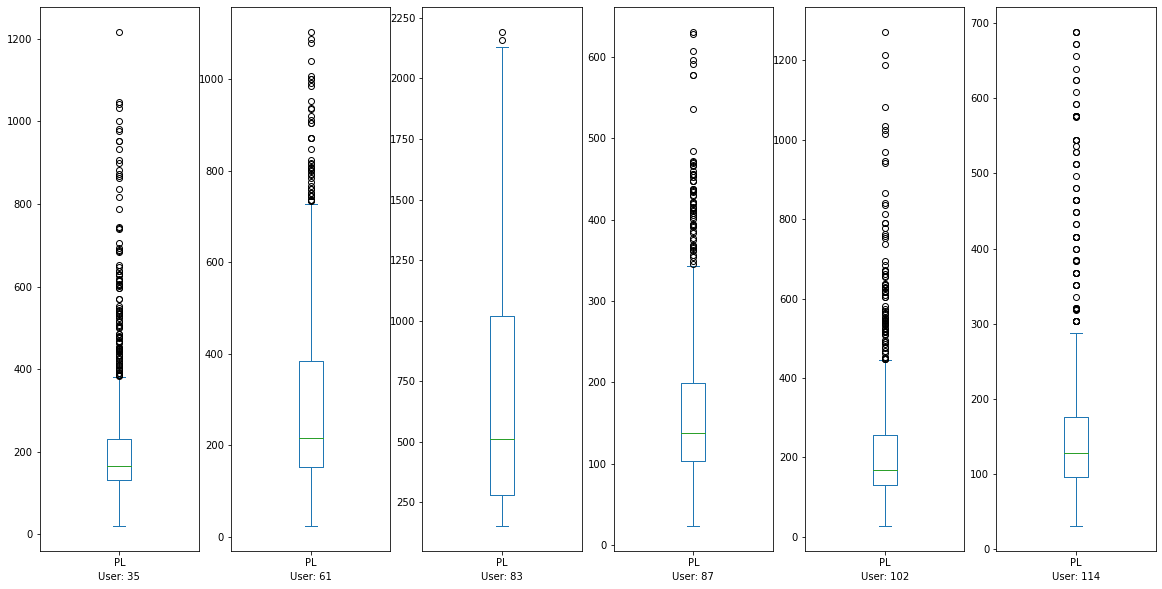

In [36]:
users = ['35', '61', '83', '87', '102', '114']
fig, ax = plt.subplots(1, 6, figsize=(20, 10))
for i, user in enumerate(users):
    mask = filtered_data['USER'] == user
    filtered_data.loc[mask, 'PL'].plot.box(ax=ax[i])
    ax[i].set_xlabel(f'User: {user}')

### Some ranomd unfiltered data user's Press Latency Distribution

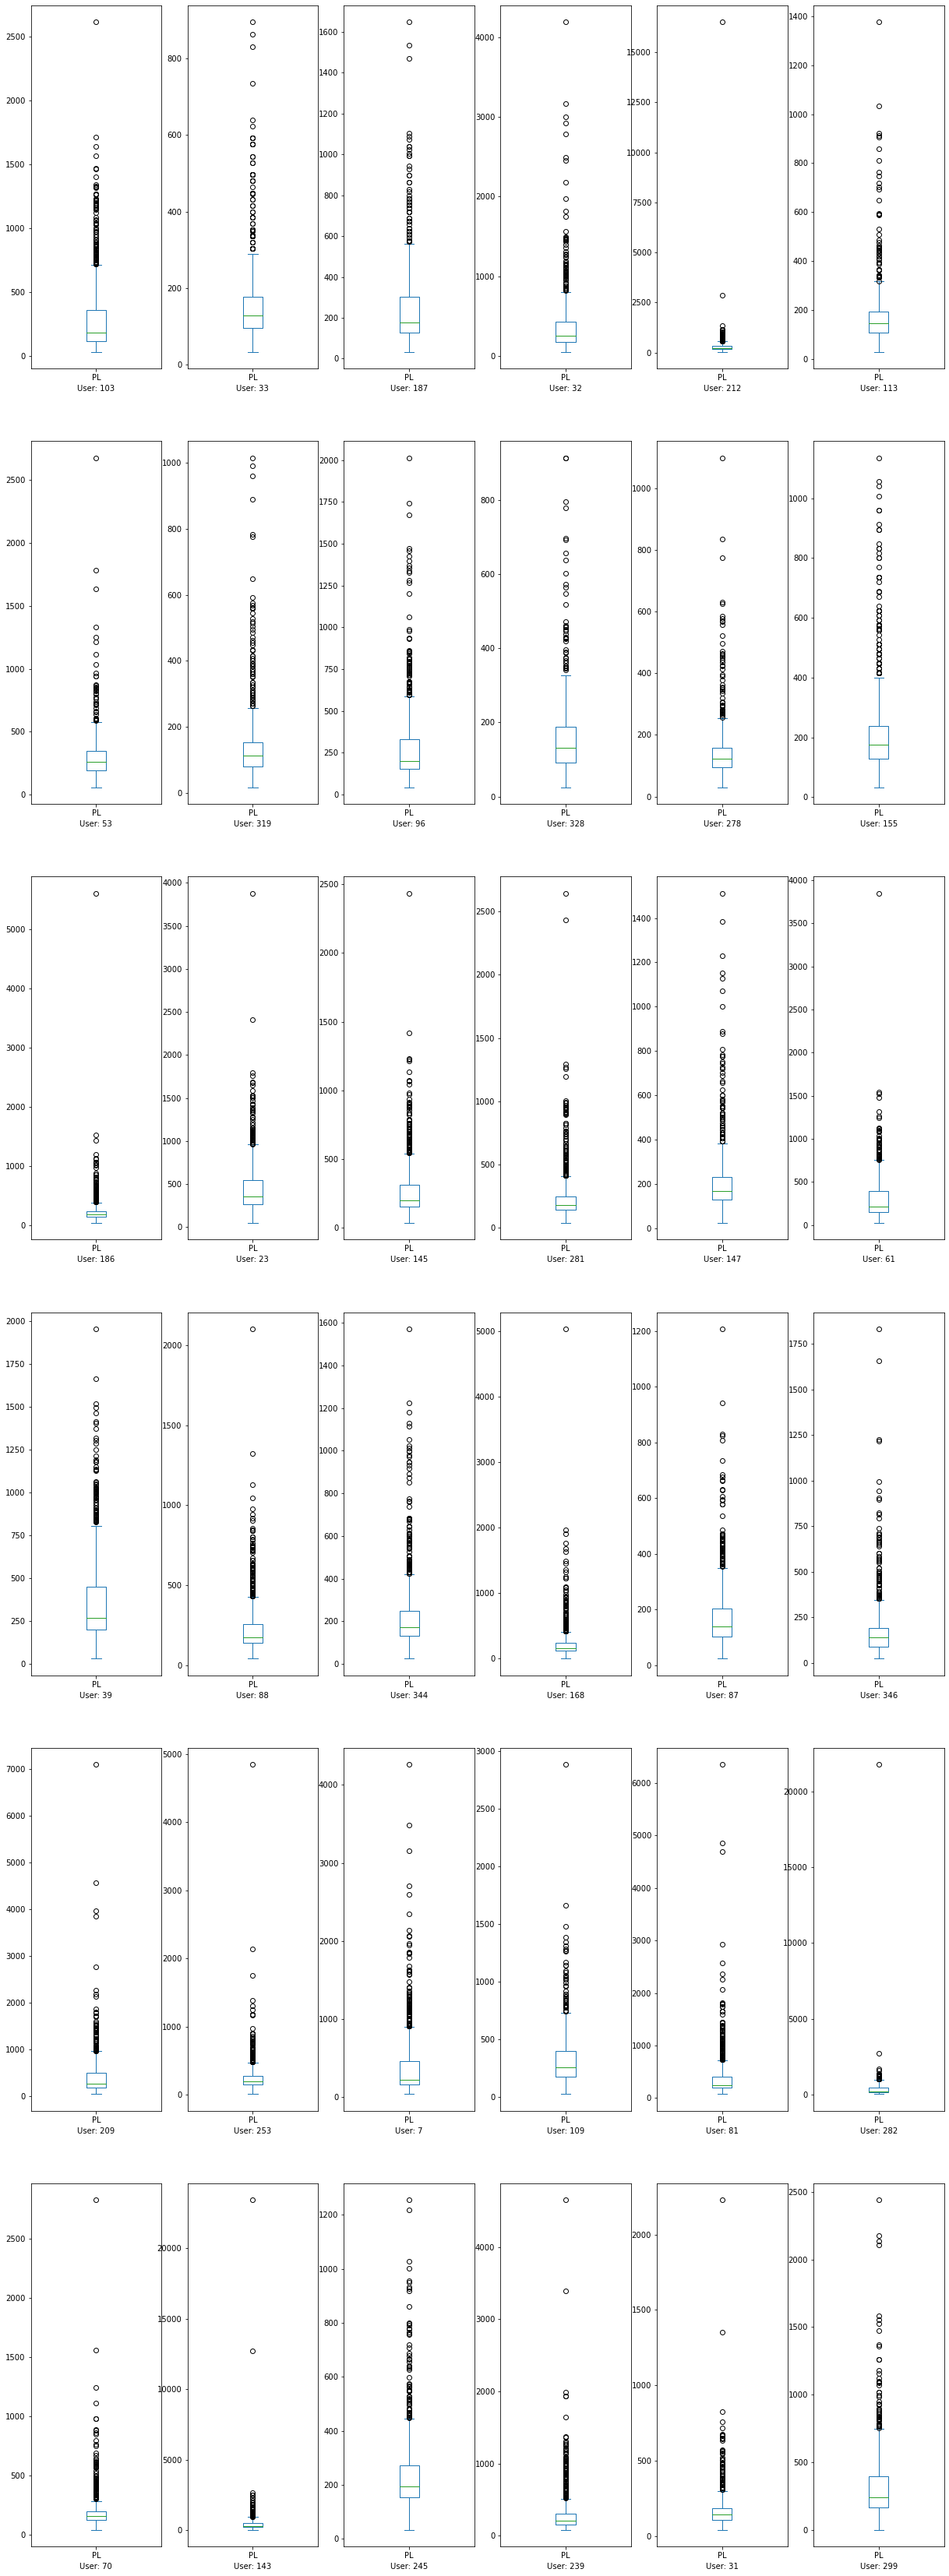

In [37]:
helper.random_boxplot(unfiltered_data)

### Some ranomd filtered data user's Press Latency Distribution

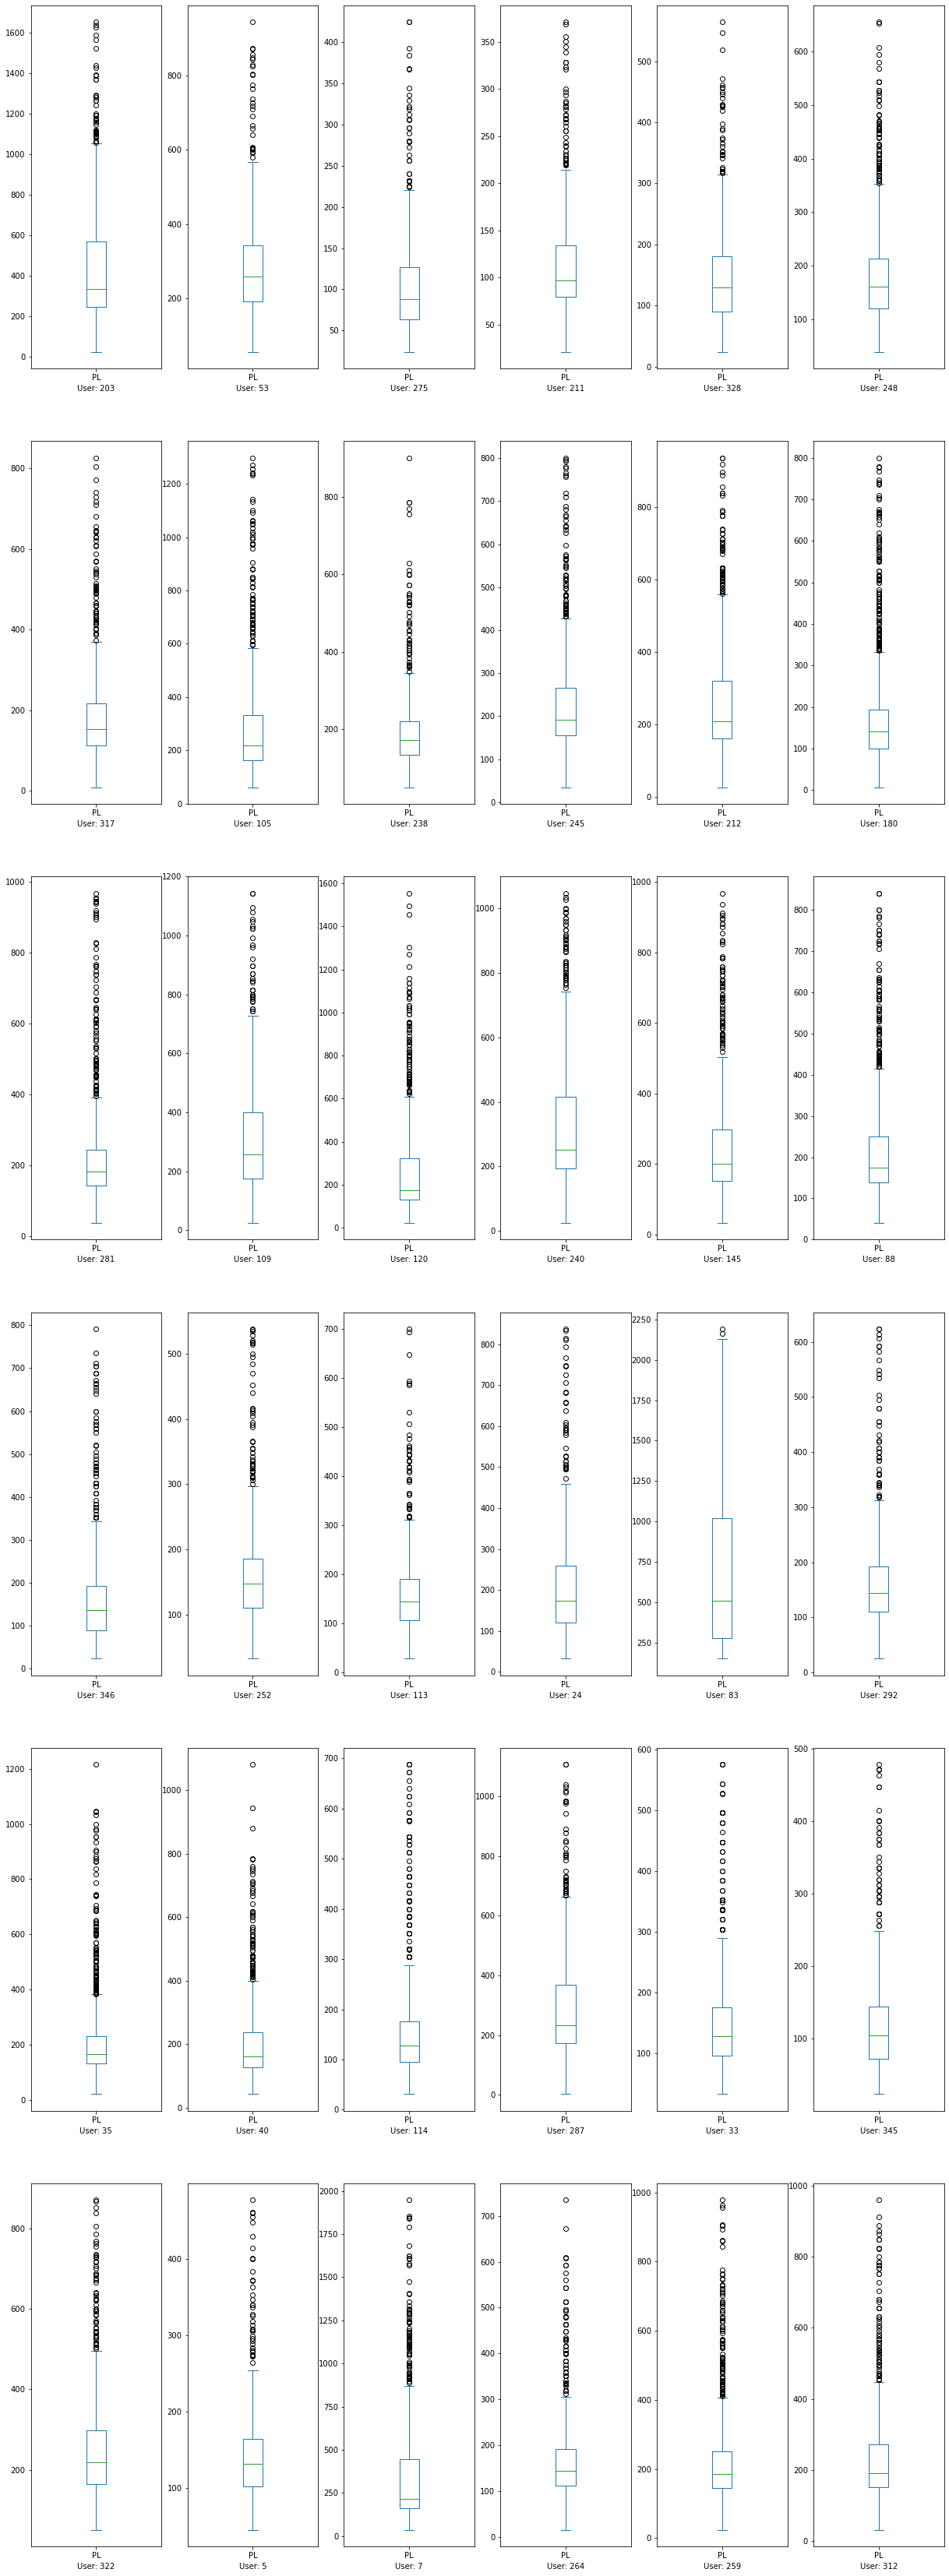

In [38]:
helper.random_boxplot(filtered_data)

## KDI: Image-Like Input Format Visualization

In [39]:
digraph_keyboard = data_extractor.digraph_keyboard(None)
ds_kdi = helper.KDI(train_data, digraph_keyboard, 50, 1, 32, 40, ['I1', 'HD', 'KD', 'IL', 'RL', 'PL', 'HL'], ['I1', 'HD', 'KD'], ['HL2', 'PL'])

Metal device set to: Apple M1 Pro


2022-12-11 19:41:06.934657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 19:41:06.935018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [41]:
curr_chunk = data_extractor.digraph_keyboard(None)[:50]
keycode_dict = ds_kdi.keycode_dict
image = ds_kdi.single_input_image(curr_chunk, ['I1', 'I2', 'HD', 'KD', 'IL', 'RL', 'PL', 'HL'], 25, keycode_dict)

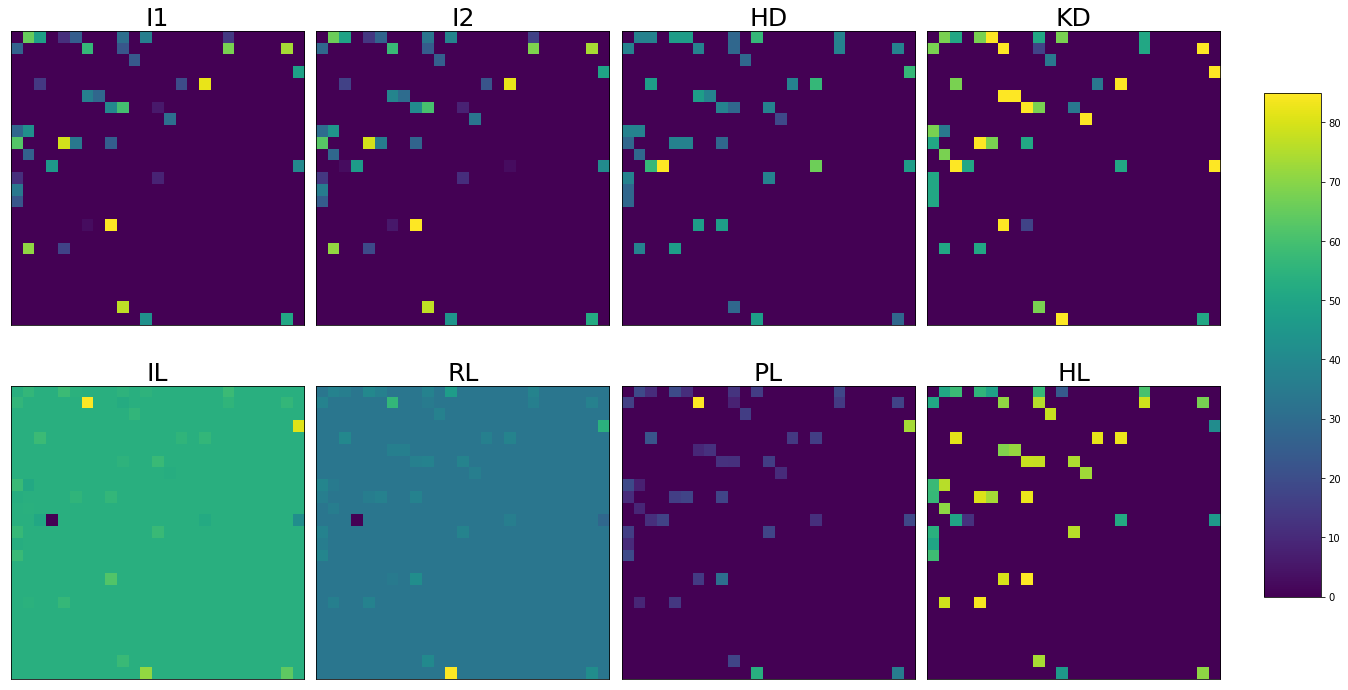

In [42]:
features = ['I1', 'I2', 'HD', 'KD', 'IL', 'RL', 'PL', 'HL']
grid = []
for i in range(8):
    grid.append(image[:, :, i])
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, im, feature in zip(axs.flat, grid, features):
    im = ax.imshow(im, interpolation='nearest', cmap='viridis')
    ax.set_title(feature, fontsize=25)

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show();